# Ablation study: separation encoding

In [1]:
import yaml
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from proteins.config import flatten_dict

ix = pd.IndexSlice
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

## Import experiment results

In [2]:
from collections import defaultdict

df = defaultdict(list)
skip = []

for p in Path('.').glob('runs/*/experiment.latest.yaml'):
    with open(p) as ex:
        ex = yaml.safe_load(ex)
    if ex['history'][-1]['status'] != 'COMPLETED':
        skip.append(p)
    else:
        df['misc', 'tags', '', ''].append(','.join(ex['tags']))
        df['misc', 'comment', '', ''].append(ex.get('comment', None))
        df['misc', 'name', '', ''].append('_'.join(ex['fullname'].split('_')[-2:]))
        df['misc', 'time', '', ''].append((ex['history'][-1]['datetime_completed'] - ex['history'][-1]['datetime_started']).total_seconds() / 60)
        df['misc', 'gpu', '', ''].append(int(ex['history'][-1]['cuda']['devices']['cuda:0']['memory_used_max'].rstrip(' MiB')))
        df['hp', 'epochs', '', ''].append(ex['completed_epochs'])
        
        for k, v in flatten_dict(ex['data']):
            df[('hp', 'data', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['model']):
            df[('hp', 'model', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['optimizer']):
            df[('hp', 'optimizer', *k, '')].append(v)
        
        for k, v in flatten_dict(ex['loss']):
            df[('hp', 'loss', *k)].append(v)
        
        for k, v in flatten_dict(ex['history'][-1]['metric']):
            df[('metric', *k, '')].append(v)
                   
df = pd.DataFrame(df).sort_index(axis='columns', inplace=False)        
print(f'Skipped {len(skip)}')
print(f'Good {len(df)}')
df.iloc[0].to_frame('Example')

Skipped 0
Good 30


Example
hp     data         cutoff                      8                                                                                                              
                    dssp                        True                                                                                                           
                    partial_entropy             True                                                                                                           
                    self_information            True                                                                                                           
       epochs                                   35                                                                                                             
       loss         global_gdtts        name    mse                                                                                                            
                                        weight  1                                                                                                              
                    local_lddt          name    mse                                                                                                            
                                        weight  5                                                                                                              
                    ranking             name    rank                                                                                                           
                                        weight  0                                                                                                              
       model        batch_norm                  False                                                                                                          
                    dropout                     0.2                                                                                                            
                    enc_in_edges                32                                                                                                             
                    enc_in_nodes                125                                                                                                            
                    fn                          proteins.networks.ProteinGN                                                                                    
                    layers                      8                                                                                                              
                    max_dist                    20                                                                                                             
                    min_dist                    0                                                                                                              
                    mp_in_edges                 128                                                                                                            
                    mp_in_globals               512                                                                                                            
                    mp_in_nodes                 512                                                                                                            
                    mp_out_edges                16                                                                                                             
                    mp_out_globals              32                                                                                                             
                    mp_out_nodes                64                                                                                                      

For each encoding type, how many experiments do we have?

In [3]:
df_counts = df.groupby(('hp','model','separation_enc')).size().to_frame('Count').rename_axis(index='Separation Encoding')
df_counts.index = df_counts.index.str.title()
display(df_counts.sort_index())
del df_counts

,Count
Separation Encoding,
Absent,10
Categorical,10
Scalar,10


### GDT_TS: Per Target Pearson

,mean,std
Separation Encoding,,
absent,0.717695,0.010404
categorical,0.727842,0.009159
scalar,0.724961,0.013871


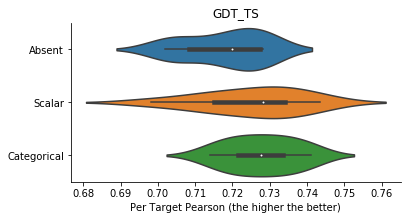

### LDDT: Per Model Pearson

,mean,std
Separation Encoding,,
absent,0.593833,0.003557
categorical,0.609353,0.003876
scalar,0.607994,0.005461


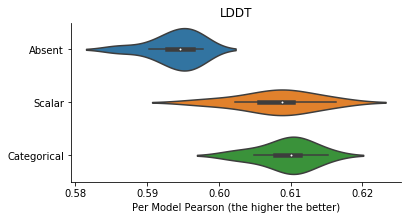

### GDT_TS: RMSE

,mean,std
Separation Encoding,,
absent,0.108664,0.003510
categorical,0.110833,0.004467
scalar,0.113019,0.004083


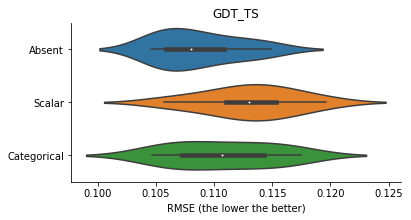

### LDDT: RMSE

,mean,std
Separation Encoding,,
absent,0.119215,0.002903
categorical,0.118945,0.002430
scalar,0.121003,0.003011


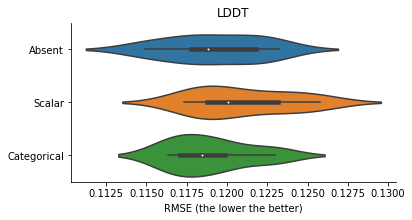

### GDT_TS: First Rank Loss

,mean,std
Separation Encoding,,
absent,0.064525,0.006643
categorical,0.066759,0.005182
scalar,0.063375,0.005262


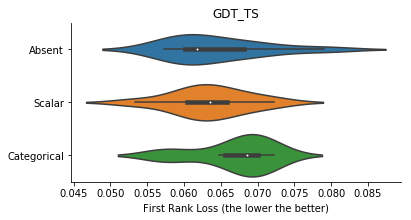

In [4]:
for title, slicer in {
    ('GDT_TS','Per Target Pearson'): ('global_gdtts','per_target_pearson',''),
    ('LDDT','Per Model Pearson'): ('local_lddt','per_model_pearson',''),
    ('GDT_TS','RMSE'): ('global_gdtts','rmse',''),
    ('LDDT','RMSE'): ('local_lddt','rmse',''),
    ('GDT_TS','First Rank Loss'): ('global_gdtts','first_rank_loss',''),
}.items():
    b = sns.catplot(
        y=('hp','model','separation_enc',''),
        x=('metric', *slicer),
        data=df,
        kind="violin", 
        aspect=2,
        height=3,
        order=['absent', 'scalar', 'categorical']
    )
    b.fig.set_facecolor('white')
    b.ax.set_yticklabels([t._text.title() for t in b.ax.get_yticklabels()])
    b.ax.set_ylabel(None)
    b.ax.set_title(title[0])
    b.ax.set_xlabel(title[1] + (' (the lower the better)' if 'Loss' in title[1] or 'RMSE' in title[1] else ' (the higher the better)'))
    
    display(Markdown(f'### {title[0]}: {title[1]}'))
    display(df.groupby(('hp','model','separation_enc','')).agg(['mean', 'std'])[('metric', *slicer)].rename_axis(index='Separation Encoding'))
    
    b.fig.savefig(f'./separation_encoding_{title[0]}_{slicer[1]}.pdf', bbox_inches='tight', pad_inches=0.01)
    display(b.fig)
    plt.close(b.fig)